In [1]:
# importing two required module 
import numpy as np
import matplotlib.pyplot as plt
import toolz
import optax
import jax.numpy as jnp
import jax
from flax import linen as nn


In [2]:
def get_point_on_a_line(vertex_1,vertex_2,weight):
    """ 
    so we want to get a section between vertex_1,vertex_2 
    we first need to calcualte a slope of the line 
    https://www.w3schools.com/datascience/ds_linear_slope.asp

    then we need to move up on a line with calculated slope as in 
    https://www.geeksforgeeks.org/find-points-at-a-given-distance-on-a-line-of-given-slope/
    """
    #we get a slope
    slope = (vertex_2[1]-vertex_1[0])/(vertex_2[0]-vertex_1[0])
    #now we need a distance travelled on a line
    vertex_diff=vertex_1-vertex_2
    l= np.sqrt(np.dot(vertex_diff,vertex_diff ))*weight

    dx = (l / np.sqrt(1 + (slope * slope)))
    dy = slope * dx
    
    return np.array([vertex_1[0]+dx, vertex_1[1]+dy])



def lineLineIntersection(A, B, C, D):
    """ 
    based on https://www.geeksforgeeks.org/program-for-point-of-intersection-of-two-lines/
    """
    # Line AB represented as a1x + b1y = c1
    a1 = B[1] - A[1]
    b1 = A[0] - B[0]
    c1 = a1*(A[0]) + b1*(A[1])
 
    # Line CD represented as a2x + b2y = c2
    a2 = D[1] - C[1]
    b2 = C[0] - D[0]
    c2 = a2*(C[0]) + b2*(C[1])
    

    determinant = (a1*b2 - a2*b1)+0.000000000001
    
    # if (determinant == 0):
    #     # The lines are parallel. This is simplified
    #     # by returning a pair of FLT_MAX
    #     return Point(10**9, 10**9)
    # else:
    x = (b2*c1 - b1*c2)/determinant
    y = (a1*c2 - a2*c1)/determinant
    return jnp.array([x, y])

def orthoProjection(vertex_a,vertex_b,vertex_c):
    """ 
    projection of a point on a line 
    adapted from https://stackoverflow.com/questions/55230528/find-point-where-altitude-meets-base-python
    """
    # abx = bx - ax
    abx = vertex_b[0] - vertex_a[0]
    # aby = by - ay
    aby = vertex_b[1] - vertex_a[1]
    # acx = cx - ax
    acx = vertex_c[0] - vertex_a[0]
    # acy = cy - ay
    acy = vertex_c[1] - vertex_a[1]
    t = (abx * acx + aby * acy) / ((abx * abx + aby * aby)+0.000000001)
    # px = ax + t * abx
    px = vertex_a[0] + t * abx
    # py = ay + t * aby
    py = vertex_a[1] + t * aby
    return jnp.array([px, py])


def get_point_on_a_line_b(vertex_0,vertex_1,weight):
    diff_x=vertex_1[0]-vertex_0[0]
    diff_y=vertex_1[1]-vertex_0[1]
    # weight=weight/2+1.5
    # weight=(weight*2)

    # C=jnp.array([vertex_0[0]+(diff_x*weight), vertex_0[1]])
    # D=jnp.array([vertex_0[0],vertex_0[1]+(diff_y*weight)])

    # alpha=np.pi/4
    # beta=-np.pi/4
    # a= vertex_0
    # #just multiplied by rotation matrix, we divide by square root of 2 in order to keep the weights in domain 1 to two
    # C= np.array([  a[0]*np.cos(alpha) + a[1]*np.sin(alpha), -a[0]*np.sin(alpha) + a[1]*np.cos(alpha)])/np.sqrt(2)
    # D= np.array([  a[0]*np.cos(beta) + a[1]*np.sin(beta), -a[0]*np.sin(beta) + a[1]*np.cos(beta)])/np.sqrt(2)
    
    # C=C*weight
    # D=D*weight
    # print(f"C {C} D {D} diff_x {diff_x} diff_y {diff_y}  vertex_0[0]{vertex_0[0]} diff_x*weight {diff_x*weight} sum {vertex_0[0]+(diff_x*weight)}")
    # return lineLineIntersection(vertex_0, vertex_1, C, D)
    return np.array([vertex_0[0]+(diff_x*weight),vertex_0[1]+(diff_y*weight)])




""" 
we want to put a new point in a triangle - that will be a new control point
point is as specified constrained by a triangle weights live on each of the primary triangle edges
so we take all three edges establish positions of temporary points by moving on those edges by percentege of their length
    taken from (sigmoided) weights we get a section by connecting two points and we get a final output point by projecting the third point on to the
    described section between previous 2 points
"""
def get_point_inside_triange(vertex_a,vertex_b,vertex_c,edge_weights):
    p0=get_point_on_a_line_b(vertex_a,vertex_b,edge_weights[0])
    p1=get_point_on_a_line_b(vertex_b,vertex_c,edge_weights[1])
    # p2=get_point_on_a_line_b(vertex_c,vertex_a,edge_weights[2])
    # print(f"p0 {p0} p1 {p1} p2 {p2}")
    res=get_point_on_a_line_b(p0,p1,edge_weights[2])
    return res,p0,p1





weights [0.52355338 0.889191   0.58970608] d [-0.06149565  5.37463912]


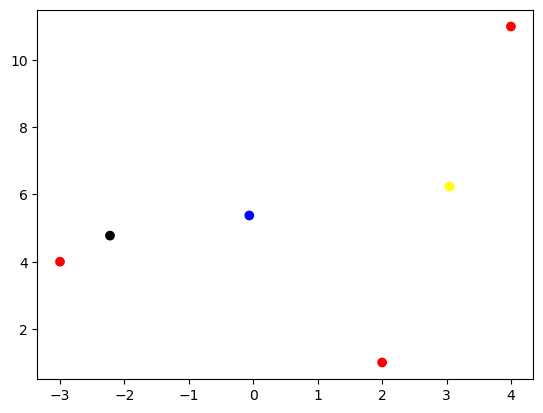

In [3]:
a=np.array([2,1])
b=np.array([4,11])
c=np.array([-3,4])
edge_weights= np.random.random(3)
# edge_weights= np.ones(3)/4


d,p0,p1=get_point_inside_triange(a,b,c,edge_weights)
print(f"weights {edge_weights} d {d}")
points_const= np.stack([a,b,c,d,p0,p1])
X,Y=list(toolz.sandbox.core.unzip(points_const))
X=list(X)
Y=list(Y)
plt.scatter(X,Y,color=['red','red','red','blue','yellow','black'])
plt.show()

[3.0, 1.0]


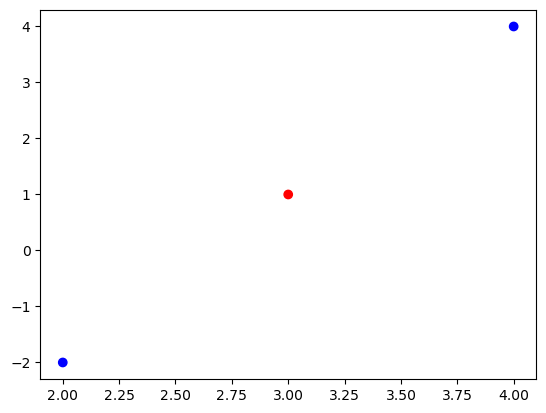

In [4]:
def get_point_on_a_line_b(vertex_0,vertex_1,weight):
    diff_x=vertex_1[0]-vertex_0[0]
    diff_y=vertex_1[1]-vertex_0[1]
    return [vertex_0[0]+(diff_x*weight),vertex_0[1]+(diff_y*weight)]

b=np.array([4,4])
a=np.array([2,-2])
# c=get_point_on_a_line_b(b,a,-0.3)
c=get_point_on_a_line_b(b,a,0.5)
print(c)
points_const= np.stack([b,a,c])
X,Y=list(toolz.sandbox.core.unzip(points_const))
X=list(X)
Y=list(Y)
plt.scatter(X,Y,color=['blue','blue','red'])
plt.show()

In [5]:
a=np.array([0,8,7,3])
a[1:-2]
a[0:-3]

array([0])

In [6]:
import einops
import itertools
def get_triangles_data():
    """ 
    manually setting data about what triangles are present in each square 
    it is based on set of sv centers and control points - also comments are to the upper left square of the image in 
    /workspaces/jax_cpu_experiments_b/geometric_sv_idea/triangle_geometric_sv.jpg
    we will also use the id of nodes as in the image bottom right
    single triangle data will consist of 4 entries - first 3 will be verticies ids as in image and the last one the id of the sv that is owner of this node
        as in the alpha order 
    we also organize triangles in primary triangles what is very usefull for additional control points managament    
    """
    return jnp.array([
          [[0,8,7,3]#I
         ,[0,8,1,0]]#A

         ,[[0,2,1,0]#B
         ,[0,2,3,1]]#C

         ,[[0,4,3,1]#D
         ,[0,4,5,2]]#L

         ,[[0,6,5,2]#K
         ,[0,6,7,3]]]#J
        )



def iter_zipped(orig,new_ones):
    return list(map(lambda triang: iter_zipped_inner(triang,new_ones) ,orig  ))

def iter_zipped_inner(triang,new_ones):
    on_border=np.append([triang[0]],new_ones)
    on_border=np.append(on_border,[triang[1]])
    # print(f"on_border {on_border}")
    # on_border=[triang[0]]+new_ones
    # on_border=np.array(on_border)
    # on_border=np.flip(np.array(on_border),axis=0)
    # print(f"orig {triang} new_ones {new_ones} on_border {on_border}")
    return list(map(lambda i: [on_border[i],on_border[i+1],triang[2],triang[3]]  ,range(len(on_border)-1)))

def get_modified_triangles_data(num_additional_points,primary_control_points_offset):
    """ 
    as we can add variable number of additional control points we need also to include them in the analysis
    """
    triangles_data= get_triangles_data()
    triangles_data= np.array(triangles_data)
    triangles_data_prim= triangles_data
    #num_additional_points tell how many additional points we will insert per primary triangle
    #and we have 4 primary triangles
    triangles_data_new_entries= list(map( lambda i :np.arange(primary_control_points_offset+i*num_additional_points,primary_control_points_offset+i*num_additional_points+num_additional_points),range(4)))
    zipped= list(zip(triangles_data_prim, triangles_data_new_entries))
    triangles_data_new= list(itertools.starmap(iter_zipped,zipped ))

    res=jnp.array(triangles_data_new)
    return  einops.rearrange(res,'a b c d -> (a b c) d' )

num_additional_points=2
primary_control_points_offset=9
dat= get_modified_triangles_data(num_additional_points,primary_control_points_offset)



No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [7]:


for_reg=einops.rearrange(dat,'(a d) p -> d a p', d=2)
for_reg[0,:,0:2]

Array([[ 0,  9],
       [10,  8],
       [ 9, 10],
       [ 0, 11],
       [12,  2],
       [11, 12],
       [ 0, 13],
       [14,  4],
       [13, 14],
       [ 0, 15],
       [16,  6],
       [15, 16]], dtype=int32)

In [8]:
import numpy as np
from typing import Any, Callable, Optional, Tuple, Type, List
from jax import lax, random, numpy as jnp
import einops
import torchio as tio
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import jax
# import monai_swin_nD
import tensorflow as tf
# import monai_einops
import torch 
import einops
# import optax
from flax.training import train_state  # Useful dataclass to keep train state
from torch.utils.data import DataLoader
import h5py
import SimpleITK as sitk

# f = h5py.File('/workspaces/Jax_cuda_med/data/hdf5_loc/mytestfile.hdf5', 'w')

# pat_g=f.create_group(f"spleen/pat_0")
# pat_g.create_dataset("image", jnp.ones((10,10,10,1)))

# list(f["spleen"].keys())
# # f.create_group("spleen")
# pat_g=f.create_group("spleen/pat_1")
# f.create_dataset("spleen/pat_1/image",data= jnp.ones((10,10,10,1)))

# f.close()
# 

# slic = sitk.SLICImageFilter()
# seg  = slic.Execute(denoised_img)




spacing = (1.5,1.5,1.5)

def get_spleen_data():
    f = h5py.File('/workspaces/jax_cpu_experiments_b/hdf5_loc/mytestfile.hdf5', 'r+')
    groups = list(f.keys())
    cached_subj=[]
    #if the dataset is not yet in hdf5 we will create it
    if("spleen" not in groups):
        print("spleen not in dataset")
        data_dir='/root/data'
        train_images = sorted(
            glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
        train_labels = sorted(
            glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))


        rang=list(range(0,len(train_images)))
        subjects_list=list(map(lambda index:tio.Subject(image=tio.ScalarImage(train_images[index],),label=tio.LabelMap(train_labels[index]),imagePath=train_images[index]),rang ))
        # subjects_list_train=subjects_list[:-9]
        # subjects_list_val=subjects_list[-9:]

        transforms = [
            tio.RescaleIntensity(out_min_max=(0, 1)),
            tio.Resample(spacing),
            tio.transforms.CropOrPad((384,384,128)),
        ]
        transform = tio.Compose(transforms)
        subjects_dataset = tio.SubjectsDataset(subjects_list, transform=transform)

        cached_subj=[]
        training_loader = DataLoader(subjects_dataset, batch_size=1, num_workers=12)
        index =-1
        for subject in training_loader :
            index=index+1
            # pat_g=f.create_group(f"spleen/pat_{index}")
            # cached_subj.append(subject)
            image=subject['image'][tio.DATA].numpy()
            label=subject['label'][tio.DATA].numpy()
            # print(f"image shape {image.shape}")
            f.create_dataset(f"spleen/pat_{index}/image",data= image)
            f.create_dataset(f"spleen/pat_{index}/label",data= label)
            #### saving SLIC for some later pretraining
            slic = sitk.SLICImageFilter()
            # slic.SetMaximumNumberOfIterations(300)
            slic.SetEnforceConnectivity(True)
            image_sitk_nda=einops.rearrange(image,'bb cc a b c -> (bb cc c) b a')
            image_sitk = sitk.GetImageFromArray(image_sitk_nda)
            image_sitk.SetSpacing(spacing)

            rescalFilt=sitk.RescaleIntensityImageFilter()
            rescalFilt.SetOutputMaximum(1000)
            rescalFilt.SetOutputMinimum(0)
            image_sitk=rescalFilt.Execute(image_sitk)

            image_sitk=sitk.Cast(image_sitk, sitk.sitkInt64)
            slic_seg = slic.Execute(image_sitk)
            nda = sitk.GetArrayFromImage(slic_seg)
            nda=einops.rearrange(nda,'a b c -> 1 c b a')
            f.create_dataset(f"spleen/pat_{index}/slic",data= nda)
    #given we already have a dataset
    else:
        print("data loaded from hdf5")  

    pat_groups = list(f["spleen"].keys())
    spleenG= f["spleen"]
    # print(f"pat_groups {pat_groups}")
    grr=list(map( lambda groupp:spleenG[groupp] ,pat_groups))
    cached_subj=list(map( lambda groupp:(groupp["image"][:,:,:,:], groupp["label"][:,:,:,:],groupp["slic"][:,:,:,:]) ,grr))

    f.close()

    return cached_subj    


2023-08-14 15:04:14.033743: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import toolz
import optax
import jax.numpy as jnp
import jax
from flax import linen as nn
import einops
import seaborn as sns
from itertools import permutations
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio
import skimage.color
import skimage.filters
import skimage.measure
import os
from shape_reshape_functions import *
from functools import partial
import math
import itertools

def get_point_on_a_line_b(vertex_0,vertex_1,weight):
    diff_x=vertex_1[0]-vertex_0[0]
    diff_y=vertex_1[1]-vertex_0[1]

    return jnp.array([vertex_0[0]+(diff_x*weight),vertex_0[1]+(diff_y*weight)])

spleen_dat=get_spleen_data()

In [10]:


def get_radius_points(ver_a,ver_b,sv_center,weight):
    return jnp.stack([get_point_on_a_line_b(ver_a,sv_center,weight)
                      ,get_point_on_a_line_b(ver_b,sv_center,weight)
                      ])

v_get_radius_points=jax.vmap(get_radius_points,in_axes=(None,None,None,0))

def get_radial_weight(num_p):
    w=np.arange(num_p+2)
    w=w/w[-1]
    return w[1:-1]


def get_indicies_for_cross(n_radius,n_cross):
    indicies= jnp.arange(n_radius)
    to_repeat=jnp.pad(jnp.arange(n_cross,0,-1),(0,n_radius-n_cross))
    indicies= jnp.repeat(indicies,to_repeat)
    weights= jnp.array(list(itertools.chain(*list(map(get_radial_weight, to_repeat)))))
    return (indicies,weights)

def get_cross_points(radial,index,weight):
    return get_point_on_a_line_b(radial[index,0,:],radial[index,1,:],weight)

v_get_cross_points=jax.vmap(get_cross_points,in_axes=(None,0,0))

def sample_in_triangle(ver_a,ver_b,sv_center, image ,n_radius,n_cross,indicies_for_cross,weights_for_cross):
    pseudo_weights= jnp.arange(n_radius+1)
    # pseudo_weights=jnp.power(pseudo_weights,1.6)
    pseudo_weights=pseudo_weights/pseudo_weights[-1]
    pseudo_weights=pseudo_weights.at[0].set(pseudo_weights[0]-0.05)#subtracting in order to avoid sampling the border
    pseudo_weights=pseudo_weights[1:]
    radial=v_get_radius_points(ver_a,ver_b,sv_center,pseudo_weights)
    # we need to get copies of points as many as many cross points we want and a weight leading to points as distant from each other as possible
    cross_points=v_get_cross_points(radial,indicies_for_cross,weights_for_cross )
    radial= einops.rearrange(radial,'a b p-> (a b) p')

    # dist=(jnp.sum(jnp.dot(ver_a,sv_center).flatten())+jnp.sum(jnp.dot(ver_b,sv_center).flatten()))/2
    # dist=(jnp.sqrt(jnp.sum(jnp.dot(ver_a,sv_center).flatten()))+jnp.sqrt(jnp.sum(jnp.dot(ver_b,sv_center).flatten())))/2
    dist=(jnp.sum(jnp.dot(ver_a,sv_center).flatten())+jnp.sum(jnp.dot(ver_b,sv_center).flatten()))/2

    #adding also the sv center   
    sv_center=jnp.expand_dims(sv_center,axis=0)
    res= jnp.concatenate([radial ,cross_points,sv_center ],axis=0)
    return res,dist

v_sample_in_triangle=jax.vmap(sample_in_triangle,in_axes=(0,0,None,None,None,None,None,None))

def sample_area(contr_points, sv_center,n_radius,n_cross,image,indicies_for_cross,weights_for_cross):
    contr_points_a=contr_points
    contr_points_b=jnp.roll(contr_points,1,0)

    # sv_center=sv_centers[0,:]#TODO change
    res,dist=v_sample_in_triangle(contr_points_a,contr_points_b,sv_center, image ,n_radius,n_cross,indicies_for_cross,weights_for_cross)
    # res=einops.rearrange(res,'a b p-> (a b) p')
    return res,dist
# sample_area(square_point, center,n_radius,n_cross,image)


In [11]:
import multiprocessing as mp
import numpyro.distributions as dist
# from scipy import misc
import jax.scipy as jsp
n_radius=10
n_cross=8
square_point = jnp.array([[0,0],[20,0],[20,20],[0,20]])
indicies_for_cross,weights_for_cross=get_indicies_for_cross(n_radius,n_cross)

# def normalize_points_a(sampled_points_coords,sampled_points,center):
#     # dist=jnp.power(jnp.power((sampled_points_coords-jnp.expand_dims(center,axis=-1)),2),0.5)
#     dist=jnp.power(sampled_points_coords-jnp.expand_dims(center,axis=-1),2)
#     # dist=jnp.abs(sampled_points_coords-jnp.expand_dims(center,axis=-1))
#     dist=jnp.sum(dist,axis=0)
#     dist=dist/jnp.max(dist.flatten())
#     normalized = sampled_points*dist
#     return normalized

def map_coords_and_norm(sampled_points_coords,image_new,distt,meann):
    sampled_points_coords=einops.rearrange(sampled_points_coords,'a b -> b a')
    sampled_points=jax.scipy.ndimage.map_coordinates(image_new,sampled_points_coords,order=1)
    sampled_points=sampled_points-meann
    sampled_points= jnp.power(sampled_points,2)
    # sampled_points= jnp.abs(sampled_points)
    sampled_points= jnp.sum(sampled_points,axis=-1)
    sampled_points=jnp.sqrt(sampled_points)
    return jnp.mean(sampled_points.flatten())*distt

v_map_coords_and_norm= jax.vmap(map_coords_and_norm,in_axes=(0,None,0,None))

def sim(mean,std,center,key):
    # center = jnp.array([[np.random.randint(1,19),np.random.randint(1,19)]])
    # image = np.random.random((20,20))*10
    # image = np.random.normal(np.random.randint(1,50),np.random.randint(1,10),(20,20))
    # image = np.random.normal(mean,std,(20,20))
    image = dist.Normal(mean,std).sample(key,(20,20))

    # center= jnp.array([2,2])

    image_new=image#[:,:,0]
    # image_new[1:,1:4]=image_new[1:2,1:4]*50
    # image_new = jnp.array(image_new)

    # aaaa=sample_in_triangle(ver_a,ver_b,sv_center, image ,n_radius,n_cross,indicies_for_cross,weights_for_cross)
    
    sampled_points_coords,distt=sample_area(square_point, center,n_radius,n_cross,image,indicies_for_cross,weights_for_cross)

    # sampled_points_coords=einops.rearrange(sampled_points_coords,'c a b -> b (c a)')

    # x = jnp.linspace(-3, 3, 7)
    # window = jsp.stats.norm.pdf(x) * jsp.stats.norm.pdf(x[:, None])
    # image_new = jsp.signal.convolve(image_new, window, mode='same')
    # image_new = jsp.signal.convolve(image_new, window, mode='same')


    meann=jnp.mean(jax.scipy.ndimage.map_coordinates(image_new,einops.rearrange(sampled_points_coords,'c a b -> b (c a)'),order=1).flatten())
    # sampled_points=sampled_points-jnp.mean(sampled_points.flatten())

    sampled_points=v_map_coords_and_norm(sampled_points_coords,image_new,distt,meann)


    orig=jnp.var(image_new.flatten())
    non_normalized=jnp.mean(sampled_points.flatten())#jnp.std(sampled_points.flatten())
    # normalized= jnp.std(normalize_points_a(sampled_points_coords,sampled_points,center).flatten() )

    #!!!!!!!!! important do not normalize the sv center as distance here is 0
    #!!!!!!!!! by construction we always know weather points or sv center has bigger x/y coords so we could avoid squaring and root ...
    # ratio=orig/normalized
    # return jnp.array([orig,non_normalized,normalized,ratio])
    return jnp.array([std,non_normalized])#non_normalized,normalized,ratio
    # print(f"image {jnp.var(image)} orig {orig}  normalized {normalized}")

# v_sim=jax.vmap(sim,in_axes=(0,0,0,0))
v_sim=jax.vmap(sim,in_axes=(0,0,0,0))
v_v_sim=jax.vmap(v_sim,in_axes=(0,0,0,0))

seed = 46
num_steps = 400
key = jax.random.PRNGKey(seed)
keya,keyb,keyc,key_d=jax.random.split(key,num=4)
mean=jax.random.randint(keya, (num_steps,), 1, 19)
std=jnp.arange(0,num_steps//10)#jax.random.randint(keyb, (num_steps,1), 1, 19)
std=einops.repeat(std,'a->a b',b=10)
# std= jnp.round(std)
center=jax.random.randint(keyc, (num_steps,2), 1, 19)
keys=jax.random.split(key_d,num=num_steps)
mean= einops.rearrange(mean,'(a b) ->a b',b=10)
keys= einops.rearrange(keys,'(a b) c->a b c',b=10)

center= einops.rearrange(center,'(a b) p->a b p',b=10)
# print(f"center {center.shape} keys {keys.shape} mean {mean.shape} std {std.shape}")
# with mp.Pool(processes = mp.cpu_count()) as pool:
#     rr=pool.map(sim,range(100))
# rr=list(map(sim,range(100)))
test_arr=spleen_dat[0][0][0,0,:,:,:]
image=einops.rearrange(test_arr,'(d x ) (e y) z -> (z d e ) x y ', d=16,e=16)


simm_multi=v_v_sim(mean,std,center,keys)




In [12]:
# simm_multi_sorted=simm_multi[simm_multi[:, 0].argsort()]
# jnp.round(jnp.array(simm_multi_sorted)).astype(int)
# jnp.round(jnp.array(simm_multi)).astype(int)
in_var=jnp.mean(jnp.std(simm_multi[:,:,1],axis=1))
in_mean=jnp.mean(simm_multi[:,:,1],axis=1)

print(f"in_var {in_var}  \n in_mean \n {jnp.round(in_mean,2)} \n ")
# print(f"in_var {in_var} in_var_non_norm {in_var_non_norm} \n in_mean \n {in_mean.astype(int)} \n \n in_mean non normalized \n{in_mean_non_norm.astype(int)} \n")
jnp.round(jnp.array(simm_multi)*100,2)
(simm_multi-einops.rearrange(in_mean,'a->a 1 1'))
# we need to see weather individual values are bigger then the mean of previous section and smaller then next
def get_is_change_ok(simm_multi,index):
    # print(f"bbbbb {simm_multi.shape}")
    prev_mean=jnp.mean(simm_multi[index-1,:,1].flatten())
    next_mean=jnp.mean(simm_multi[index+1,:,1].flatten())
    curr= simm_multi[index+1,:,1]
    # curr=(np.array(curr))
    res=jnp.greater(curr,prev_mean)
    res=jnp.logical_and(res,(curr<next_mean)).astype(float)
    return jnp.mean(res.flatten())



# v_get_is_change_ok= jax.vmap(get_is_change_ok,in_axes=(None,0))

# print(f"aaaa {simm_multi.shape}")
# v_get_is_change_ok(simm_multi,jnp.arange(1,((num_steps//10))-1))
rr=list(map(lambda index:get_is_change_ok(simm_multi,index),jnp.arange(1,((num_steps//10))-1)))
jnp.mean(jnp.array(rr))

in_var 6920.4892578125  
 in_mean 
 [ 2692.6199  2699.55    1910.96    3463.53    4768.59    6923.36
  7572.9697  6621.19    8785.59    9600.95   11287.47   11762.46
 13652.85   10186.33   14541.38   12770.84   17777.15   15783.239
 18253.32   15283.38   20784.709  17626.639  18366.18   21018.309
 26100.309  27438.44   25524.11   23007.85   29264.969  34398.48
 31406.24   27694.459  27562.33   32844.56   33504.99   30825.91
 31003.34   42844.777  29957.77   33384.598 ] 
 


Array(0.16842106, dtype=float32)

data loaded from hdf5


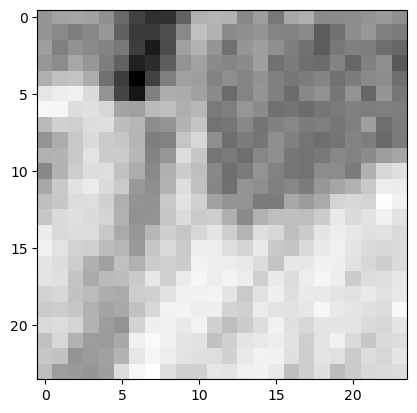

In [29]:
test_arr=spleen_dat[0][0][0,0,:,:,:]
rearranged=einops.rearrange(test_arr,'(d x ) (e y) z -> (z d e ) x y ', d=16,e=16)
plt.imshow(rearranged[150,:,:],cmap="Greys")

In [14]:
# X=aaaa[:,0]
# Y=aaaa[:,1]
# X=list(X)
# Y=list(Y)
# plt.scatter(X,Y)#,color=['blue','blue','red']
# plt.show()

# aaaa.shape
#image 142.0267791748047 calced 123.89994049072266  normalized 7130.7802734375 jnp.array([[10,10]])
#image 142.0267791748047 calced 230.17112731933594  normalized 6150.83642578125  jnp.array([[3,3]])
#image 142.0267791748047 calced 64.50949096679688  normalized 7704.2001953125 jnp.array([[15,15]])